# **CDC Diabetes Health Indicators**

In [2]:
!pip install opendatasets

  Using cached opendatasets-0.1.22-py3-none-any.whl.metadata (9.2 kB)
  Using cached kaggle-1.6.14-py3-none-any.whl
Using cached opendatasets-0.1.22-py3-none-any.whl (15 kB)


In [3]:
!pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl.metadata (355 bytes)
  Using cached imbalanced_learn-0.12.3-py3-none-any.whl.metadata (8.3 kB)
Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
Using cached imbalanced_learn-0.12.3-py3-none-any.whl (258 kB)


In [4]:
!pip install xgboost

  Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl.metadata (2.0 kB)
Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl (297.1 MB)


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import os
import boto3
import sagemaker

from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
import xgboost
import opendatasets as od

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


# **Collect Data**

In [6]:
od.download('https://www.kaggle.com/alexteboul/diabetes-health-indicators-dataset')

Skipping, found downloaded files in "./diabetes-health-indicators-dataset" (use force=True to force download)


In [7]:
os.listdir('diabetes-health-indicators-dataset')

['diabetes_012_health_indicators_BRFSS2015.csv',
 'diabetes_binary_health_indicators_BRFSS2015.csv',
 'diabetes_binary_5050split_health_indicators_BRFSS2015.csv']

In [8]:
# dataset = pd.read_csv('./diabetes-health-indicators-dataset/diabetes_binary_health_indicators_BRFSS2015.csv')
dataset = pd.read_csv('./diabetes-health-indicators-dataset/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
dataset

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,4.0,1.0
70688,1.0,0.0,1.0,1.0,29.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,2.0,0.0,0.0,1.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,1.0,25.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,5.0,15.0,0.0,1.0,0.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0


# **Review Data**

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

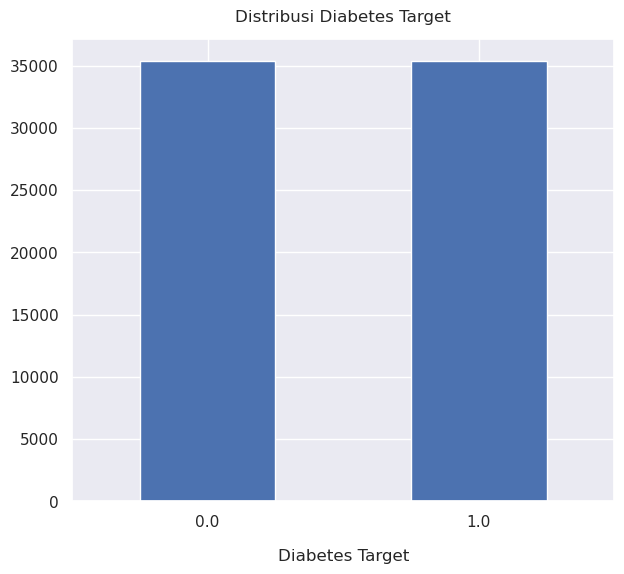

Diabetes_binary
0.0    35346
1.0    35346
Name: count, dtype: int64


In [10]:
sns.set(font_scale=1.0)
dataset['Diabetes_binary'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Diabetes Target", labelpad=14)
plt.title("Distribusi Diabetes Target", y=1.02);
plt.show()

print(dataset['Diabetes_binary'].value_counts())

## Check Missing Values

In [11]:
dataset.isnull().sum()

Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

## Check Duplicate Data

In [12]:
duplicate_rows = dataset.duplicated()
print("All Duplicate Rows:")
dataset[dataset.duplicated(keep=False)]

All Duplicate Rows:


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0
12,0.0,1.0,1.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,1.0,7.0,6.0,8.0
20,0.0,0.0,0.0,1.0,22.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,6.0,8.0
58,0.0,0.0,0.0,1.0,23.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,6.0,8.0
86,0.0,0.0,0.0,1.0,33.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,6.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69865,1.0,1.0,1.0,1.0,27.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,4.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
69939,1.0,1.0,1.0,1.0,27.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
70305,1.0,1.0,0.0,1.0,30.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,9.0,4.0,7.0
70591,1.0,1.0,1.0,1.0,30.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,1.0,10.0,6.0,8.0


In [13]:
dataClean = dataset.drop_duplicates()
print("All Duplicate Rows:")
dataClean[dataClean.duplicated(keep=False)]

All Duplicate Rows:


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income


In [14]:
dataClean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69057 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       69057 non-null  float64
 1   HighBP                69057 non-null  float64
 2   HighChol              69057 non-null  float64
 3   CholCheck             69057 non-null  float64
 4   BMI                   69057 non-null  float64
 5   Smoker                69057 non-null  float64
 6   Stroke                69057 non-null  float64
 7   HeartDiseaseorAttack  69057 non-null  float64
 8   PhysActivity          69057 non-null  float64
 9   Fruits                69057 non-null  float64
 10  Veggies               69057 non-null  float64
 11  HvyAlcoholConsump     69057 non-null  float64
 12  AnyHealthcare         69057 non-null  float64
 13  NoDocbcCost           69057 non-null  float64
 14  GenHlth               69057 non-null  float64
 15  MentHlth              69

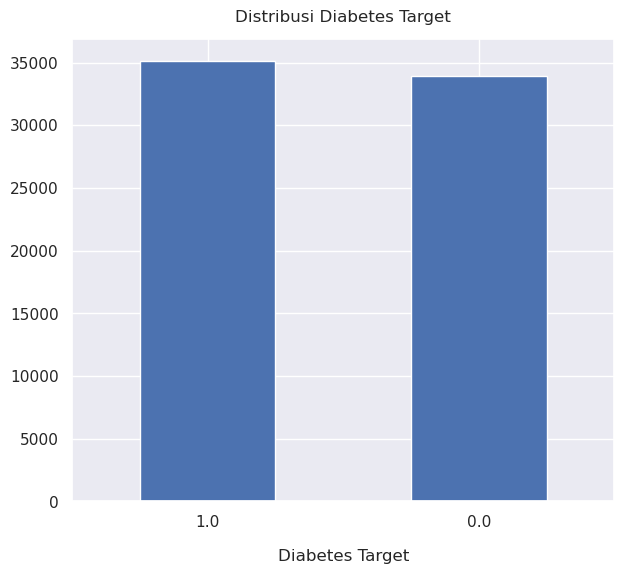

Diabetes_binary
1.0    35097
0.0    33960
Name: count, dtype: int64


In [15]:
sns.set(font_scale=1.0)
dataClean['Diabetes_binary'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Diabetes Target", labelpad=14)
plt.title("Distribusi Diabetes Target", y=1.02);
plt.show()

print(dataClean['Diabetes_binary'].value_counts())

# **Balance Data**

In [16]:
X = dataClean.drop(['Diabetes_binary'], axis = 1).values
y = dataClean['Diabetes_binary']

# **Split Data**

In [17]:
# Initial split: 60% for training, validation, and testing; 40% for production
X_temp, X_prod, y_temp, y_prod = train_test_split(X, y, test_size=0.4, random_state=42)

# Further split the 60% into 40% training, 10% validation, and 10% testing
# 2/3 of 60% (or 40% of the original) goes to training; 1/6 each for validation and testing (10% of the original each)
X_train, X_temp, y_train, y_temp = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Extract 10% batch inference from the production dataset
X_batch, _ = train_test_split(X_prod, train_size=0.25, random_state=42)

# Print the sizes of each subset to verify
print(f'Training set size: {X_train.shape[0]}')
print(f'Validation set size: {X_val.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')
print(f'Production set size: {X_prod.shape[0]}')
print(f"Batch inference set: {len(X_batch)} samples")

Training set size: 27622
Validation set size: 6906
Test set size: 6906
Production set size: 27623
Batch inference set: 6905 samples


## Split Data into Train, Validation, Test, and Production sets

In [18]:
# Assuming features have column names stored in a list called feature_names
feature_names = dataClean.drop(['Diabetes_binary'], axis=1).columns

# Convert numpy arrays to pandas DataFrames and reset the indices
X_train_df = pd.DataFrame(X_train, columns=feature_names).reset_index(drop=True)
X_val_df = pd.DataFrame(X_val, columns=feature_names).reset_index(drop=True)
X_test_df = pd.DataFrame(X_test, columns=feature_names).reset_index(drop=True)
X_prod_df = pd.DataFrame(X_prod, columns=feature_names).reset_index(drop=True)

# Convert labels to DataFrames and reset the indices
y_train_df = pd.DataFrame(y_train, columns=['Diabetes_binary']).reset_index(drop=True)
y_val_df = pd.DataFrame(y_val, columns=['Diabetes_binary']).reset_index(drop=True)
y_test_df = pd.DataFrame(y_test, columns=['Diabetes_binary']).reset_index(drop=True)
y_prod_df = pd.DataFrame(y_prod, columns=['Diabetes_binary']).reset_index(drop=True)

# Concatenate features and labels
train_df = pd.concat([y_train_df, X_train_df], axis=1)
val_df = pd.concat([y_val_df, X_val_df], axis=1)
test_df = pd.concat([y_test_df, X_test_df], axis=1)
prod_df = pd.concat([y_prod_df, X_prod_df], axis=1)
batch_df = pd.DataFrame(X_batch, columns=feature_names)

In [19]:
# Print the first few rows of each DataFrame to verify
print("Training Set:")
train_df.head()

Training Set:


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,1.0,0.0,1.0,27.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,1.0,1.0,10.0,6.0,8.0
1,0.0,0.0,1.0,1.0,30.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,2.0,4.0,0.0,0.0,9.0,5.0,7.0
2,0.0,1.0,0.0,1.0,23.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,5.0,0.0,20.0,0.0,1.0,11.0,5.0,8.0
3,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,30.0,0.0,0.0,0.0,4.0,5.0,6.0
4,1.0,0.0,1.0,1.0,24.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,30.0,0.0,0.0,10.0,4.0,7.0


In [20]:
# Print the first few rows of each DataFrame to verify
print("Batch Set:")
batch_df.head()

Batch Set:


,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,1.0,1.0,29.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,4.0,30.0,5.0,0.0,0.0,6.0,4.0,3.0
1,1.0,1.0,1.0,30.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,6.0,7.0
2,0.0,0.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,10.0,5.0,6.0
3,0.0,1.0,1.0,23.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,3.0,27.0,29.0,0.0,0.0,8.0,6.0,6.0
4,1.0,0.0,1.0,33.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,10.0,6.0,4.0


In [21]:
# Use 'csv' format to store the data
# The first column is expected to be the output column
train_df.to_csv('train.csv', index=False, header=False)
val_df.to_csv('validation.csv', index=False, header=False)
test_df.to_csv('test.csv', index=False, header=False)
prod_df.to_csv('production.csv', index=False, header=False)
batch_df.to_csv('batch.csv', index=False, header=False)

In [22]:
train_df.columns

Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

## Upload Train, Validation, Test, and Production csv files to S3

In [23]:
bucket = sagemaker.Session().default_bucket()
prefix = "demo-sagemaker-xgboost-Diabetes-prediction"

boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'production/production.csv')).upload_file('production.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'batch/batch.csv')).upload_file('batch.csv')

In [24]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>